# Adversarial attack in models of sequential data (ADA)


In [1]:
!git clone https://github.com/bbogdanovaalina/Adversarial-Attacks-for-Sequential-Data-Models.git

Cloning into 'Adversarial-Attacks-for-Sequential-Data-Models'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 0), reused 11 (delta 0), pack-reused 0
Receiving objects: 100% (15/15), 58.67 KiB | 5.87 MiB/s, done.


In [1]:
%%capture
!pip install -U aeon

In [2]:
# Import models
from src.models import GenClass, CNN, Encoder, LSTMModel

In [3]:
import os
import aeon
from aeon.datasets import load_from_tsfile
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import math

In [4]:
# Collab
#Home_dir = 'content/Adversarial-Attacks-for-Sequential-Data-Models'

# Local
Home_dir = os.getcwd()
print(Home_dir)

/Users/nikitaligostaev/Documents/HWandLessons/MSD/Project/repo/Adversarial-Attacks-for-Sequential-Data-Models


In [5]:
def metrics(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred)
    ras = roc_auc_score(true, pred)

    return {
        'accuracy_score': acc,
        'f1_score': f1,
        'roc_auc_score': ras
    }

### Preliminaries with timeseries data

In [6]:
FordA_data_path = os.path.join(os.path.dirname(aeon.__file__), f"{Home_dir}/data/FordA")

x_train, y_train = load_from_tsfile(FordA_data_path + "/FordA_TRAIN.ts")
x_test, y_test = load_from_tsfile(FordA_data_path + "/FordA_TEST.ts")

In [7]:
Chinatown_data_path = os.path.join(os.path.dirname(aeon.__file__), f"{Home_dir}/data/Chinatown")

x_train, y_train = load_from_tsfile(Chinatown_data_path + "/Chinatown_TRAIN.ts")
x_test, y_test = load_from_tsfile(Chinatown_data_path + "/Chinatown_TEST.ts")

In [8]:
Wine_data_path = os.path.join(os.path.dirname(aeon.__file__), f"{Home_dir}/data/Wine")

x_train, y_train = load_from_tsfile(Wine_data_path + "/Wine_TRAIN.ts")
x_test, y_test = load_from_tsfile(Wine_data_path + "/Wine_TEST.ts")

In [9]:
x_combined = np.vstack((x_train, x_test))
y_combined = np.hstack((y_train, y_test))

In [10]:
x_combined.shape

(111, 1, 234)

In [11]:
y_combined.shape

(111,)

In [12]:
x_train, x_temp, y_train, y_temp = train_test_split(x_combined, y_combined, train_size = 0.6, test_size = 0.4, random_state = 0xC0FFEE)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size = 0.5, test_size = 0.5, random_state = 0xC0FFEE)

In [13]:
x_train.shape

(66, 1, 234)

In [14]:
x_test.shape

(23, 1, 234)

In [15]:
x_val.shape

(22, 1, 234)

In [16]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

In [17]:
classes = np.unique(np.concatenate((y_train, y_test)))
classes

array([1, 2])

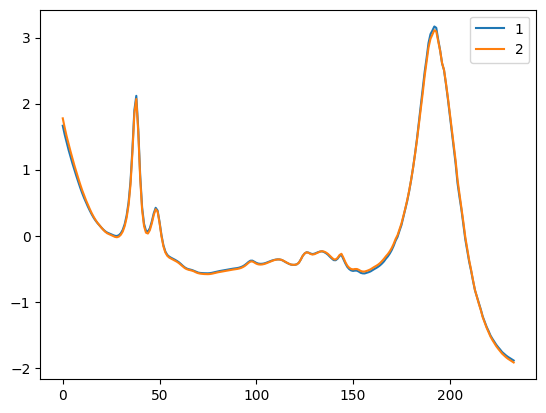

In [18]:
i = 1
for c in classes:
    c_x = x_train[y_train == c]
    plt.plot(c_x[i][0], label = c)
    plt.legend()

In [19]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [20]:
# For FordA
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
y_val[y_val == -1] = 0

In [21]:
# For wine & chinatown
y_train[y_train == 2] = 0
y_test[y_test == 2] = 0
y_val[y_val == 2] = 0

In [22]:
classes = np.unique(np.concatenate((y_train, y_test)))
classes

array([0, 1])

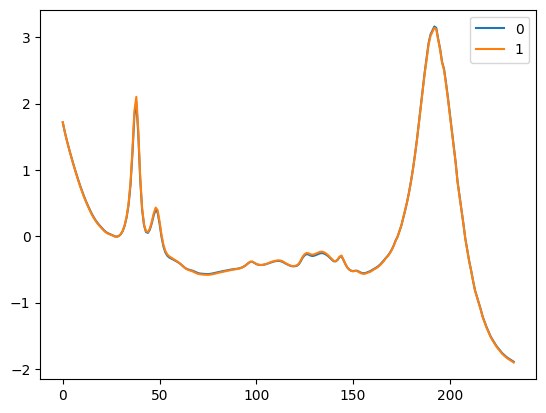

In [23]:
i = 1
for c in classes:
    c_x = x_train[y_train == c]
    plt.plot(c_x[i][0], label = c)
    plt.legend()

### Dataloader

In [24]:
from torch.utils.data import Dataset, DataLoader

class FordADataset(Dataset):
    def __init__(self, root_path, flag):
        if flag == 'TRAIN':
            self.X_data, self.y_data = load_from_tsfile(
                root_path + "/FordA_TRAIN.ts"
            )
        elif flag == 'TEST':
            self.X_data, self.y_data = load_from_tsfile(
                root_path + "/FordA_TEST.ts"
            )
        
        self.y_data = self.y_data .astype(int)

        self.y_data[self.y_data == 2] = 0
        self.y_data = torch.from_numpy(self.y_data).long()
        self.X_data = torch.from_numpy(self.X_data).float()
        self.max_seq_len = self.X_data.shape[1]
        self.feature_df = torch.randn(size = (1, 1))
        self.class_names = [0, 1]
        
    def __getitem__(self, index):
        x = self.X_data[index].unsqueeze(-1)
        y = self.y_data[index]

        return x, y
        
    def __len__ (self):
        return len(self.X_data)
    

class ChinatownDataset(Dataset):
    def __init__(self, root_path, flag):
        if flag == 'TRAIN':
            self.X_data, self.y_data = load_from_tsfile(
                root_path + "/Chinatown_TRAIN.ts"
            )
        elif flag == 'TEST':
            self.X_data, self.y_data = load_from_tsfile(
                root_path + "/Chinatown_TEST.ts"
            )
        
        self.y_data = self.y_data .astype(int)

        self.y_data[self.y_data == 2] = 0
        self.y_data = torch.from_numpy(self.y_data).long()
        self.X_data = torch.from_numpy(self.X_data).float()
        self.max_seq_len = self.X_data.shape[1]
        self.feature_df = torch.randn(size = (1, 1))
        self.class_names = [0, 1]
        
    def __getitem__(self, index):
        x = self.X_data[index].unsqueeze(-1)
        y = self.y_data[index]

        return x, y
        
    def __len__ (self):
        return len(self.X_data)
    

class WineDataset(Dataset):
    def __init__(self, root_path, flag):
        if flag == 'TRAIN':
            self.X_data, self.y_data = load_from_tsfile(
                root_path + "/Wine_TRAIN.ts"
            )
        elif flag == 'TEST':
            self.X_data, self.y_data = load_from_tsfile(
                root_path + "/Wine_TEST.ts"
            )
        
        self.y_data = self.y_data .astype(int)

        self.y_data[self.y_data == 2] = 0
        self.y_data = torch.from_numpy(self.y_data).long()
        self.X_data = torch.from_numpy(self.X_data).float()
        self.max_seq_len = self.X_data.shape[1]
        self.feature_df = torch.randn(size = (1, 1))
        self.class_names = [0, 1]
        
    def __getitem__(self, index):
        x = self.X_data[index].unsqueeze(-1)
        y = self.y_data[index]

        return x, y
        
    def __len__ (self):
        return len(self.X_data)

In [25]:
FordA_data_path = os.path.join(os.path.dirname(aeon.__file__), f"{Home_dir}/data/FordA")
Chinatown_data_path = os.path.join(os.path.dirname(aeon.__file__), f"{Home_dir}/data/Chinatown")
Wine_data_path = os.path.join(os.path.dirname(aeon.__file__), f"{Home_dir}/data/Wine")

# FordA
train_data = FordADataset(FordA_data_path, 'TRAIN')
test_data = FordADataset(FordA_data_path, 'TEST')

# Chinatown
train_data = ChinatownDataset(Chinatown_data_path, 'TRAIN')
test_data = ChinatownDataset(Chinatown_data_path, 'TEST')

# Wine
train_data = WineDataset(Wine_data_path, 'TRAIN')
test_data = WineDataset(Wine_data_path, 'TEST')

BATCH_SIZE = 128

train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE)

In [15]:
def set_lr(optim, lr):
    for p in optim.param_groups:
        p['lr'] = lr
    print(f'Lr is adjusted to {lr}')

In [16]:
def cosine_annealing_lr(epoch, num_epochs, initial_lr):
    return initial_lr * 0.5 * (1 + math.cos(math.pi * epoch / num_epochs))

In [17]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [18]:
#define parameters
in_ch = 1
d_model = 64
features = [128, 256, 512] # for cnn
act_func = nn.GELU
kernel_size = 3
dilation = 1 # not change
num_layers = 3
dropout = 0.1
n_heads = 8

In [19]:
cnn = CNN(in_ch=d_model, out_ch=d_model, features=features, kernel_size=3, dilation=dilation, act_func=act_func)
lstm = LSTMModel(input_dim=d_model, embed_dim=d_model, num_layers=num_layers, dropout_prob=dropout)
encoder = Encoder(d_model=d_model, n_heads=n_heads, n_layers=num_layers,dropout=dropout)

In [20]:
model = GenClass(in_ch=in_ch, d_model=d_model, models=[cnn], num_classes=2).to(device)

In [21]:
n_epochs = 15
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

In [22]:
###FIT model

train_losses = []
test_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_tar = []
    train_pred = []
    epoch_train_loss = 0

    for batch_cat, batch_target in tqdm(train_loader, desc = "Training"):

        batch_cat, batch_target = batch_cat.to(device), batch_target.to(device)

        optimizer.zero_grad()

        output = model(batch_cat)

        loss = loss_func(output, batch_target)

        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_tar.extend(batch_target.cpu().tolist())
        train_pred.extend(output.detach().cpu().argmax(-1).tolist())

    train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1} || Train loss {epoch_train_loss / len(train_loader.dataset)}')
    print(metrics(train_tar, train_pred))

    with torch.no_grad():
        model.train(False)
        epoch_valid_loss = 0
        val_tar = []
        val_pred = []
        for batch_tuple in tqdm(test_loader, desc = "Testing"):
            (batch_cat, batch_target) = batch_tuple
            batch_cat, batch_target = batch_cat.to(device), batch_target.to(device)

            output = model(batch_cat)

            loss = loss_func(output, batch_target)

            epoch_valid_loss += loss.item()
            val_tar.extend(batch_target.cpu().tolist())
            val_pred.extend(output.detach().cpu().argmax(-1).tolist())

        test_loss = epoch_valid_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        print(f'Epoch {epoch+1} || Valid loss {epoch_valid_loss / len(test_loader.dataset)}')
        print(metrics(val_tar, val_pred))

    set_lr(optimizer, cosine_annealing_lr(epoch, n_epochs, lr))


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1 || Train loss 0.008656954325030029
{'accuracy_score': 0.5367953346292696, 'f1_score': 0.5472312703583061, 'roc_auc_score': 0.5377211989888047}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 || Valid loss 0.005707092086474101
{'accuracy_score': 0.5159090909090909, 'f1_score': 0.0, 'roc_auc_score': 0.5}
Lr is adjusted to 0.001


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2 || Train loss 0.005267721171247995
{'accuracy_score': 0.5853929464037767, 'f1_score': 0.5759727350184606, 'roc_auc_score': 0.5852052485855302}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 || Valid loss 0.005158506830533345
{'accuracy_score': 0.6992424242424242, 'f1_score': 0.6286248830682882, 'roc_auc_score': 0.6938946454054725}
Lr is adjusted to 0.0009890738003669028


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3 || Train loss 0.004057957517938526
{'accuracy_score': 0.7231324632046654, 'f1_score': 0.736313144670722, 'roc_auc_score': 0.7248585530275671}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 || Valid loss 0.005284338918599215
{'accuracy_score': 0.6234848484848485, 'f1_score': 0.4544456641053787, 'roc_auc_score': 0.614247895596782}
Lr is adjusted to 0.0009567727288213005


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4 || Train loss 0.00354532409594874
{'accuracy_score': 0.7725631768953068, 'f1_score': 0.7647227808101119, 'roc_auc_score': 0.7722141968620841}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 || Valid loss 0.0039037750300132865
{'accuracy_score': 0.740909090909091, 'f1_score': 0.7598314606741573, 'roc_auc_score': 0.7441693725741625}
Lr is adjusted to 0.0009045084971874737


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5 || Train loss 0.0033057043284914355
{'accuracy_score': 0.7903360177728409, 'f1_score': 0.7810959698463323, 'roc_auc_score': 0.7897736848441074}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 || Valid loss 0.004445821904774868
{'accuracy_score': 0.7553030303030303, 'f1_score': 0.7144120247568524, 'roc_auc_score': 0.7515080694642648}
Lr is adjusted to 0.0008345653031794292


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6 || Train loss 0.003112608469118512
{'accuracy_score': 0.8064426548181061, 'f1_score': 0.7957808379724581, 'roc_auc_score': 0.8056378154969706}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 || Valid loss 0.003302201448064862
{'accuracy_score': 0.7946969696969697, 'f1_score': 0.80711743772242, 'roc_auc_score': 0.7975533081011769}
Lr is adjusted to 0.00075


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7 || Train loss 0.0030217315878546328
{'accuracy_score': 0.8169952790891419, 'f1_score': 0.806461086637298, 'roc_auc_score': 0.8161410055776253}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 || Valid loss 0.003558069332079454
{'accuracy_score': 0.781060606060606, 'f1_score': 0.7888970051132213, 'roc_auc_score': 0.783034477053215}
Lr is adjusted to 0.0006545084971874737


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8 || Train loss 0.0029040950846254943
{'accuracy_score': 0.8242154956956401, 'f1_score': 0.8131089459698849, 'roc_auc_score': 0.8232394366197182}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 || Valid loss 0.0031639591310963487
{'accuracy_score': 0.8143939393939394, 'f1_score': 0.8032128514056224, 'roc_auc_score': 0.8134095813254465}
Lr is adjusted to 0.0005522642316338268


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9 || Train loss 0.0028478038191828456
{'accuracy_score': 0.8283810052763121, 'f1_score': 0.8181283107710418, 'roc_auc_score': 0.8274848521327396}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 || Valid loss 0.002938119615569259
{'accuracy_score': 0.8348484848484848, 'f1_score': 0.8269841269841269, 'roc_auc_score': 0.834246792551688}
Lr is adjusted to 0.00044773576836617336


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10 || Train loss 0.0027518377506676665
{'accuracy_score': 0.8386559289086365, 'f1_score': 0.8290673727566931, 'roc_auc_score': 0.8377733638297019}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 || Valid loss 0.002973565526983955
{'accuracy_score': 0.8303030303030303, 'f1_score': 0.8255451713395638, 'roc_auc_score': 0.8302758302137839}
Lr is adjusted to 0.00034549150281252633


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11 || Train loss 0.002675857900811778
{'accuracy_score': 0.8405998333796167, 'f1_score': 0.8309776207302709, 'roc_auc_score': 0.839697443922796}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 || Valid loss 0.00300693286187721
{'accuracy_score': 0.825, 'f1_score': 0.7993049522154648, 'roc_auc_score': 0.8217582538796163}
Lr is adjusted to 0.0002500000000000001


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 12 || Train loss 0.002648143123103923
{'accuracy_score': 0.8444876423215774, 'f1_score': 0.8342214328004736, 'roc_auc_score': 0.8434613378275351}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 || Valid loss 0.00481682891647021
{'accuracy_score': 0.7378787878787879, 'f1_score': 0.6357894736842105, 'roc_auc_score': 0.7296987997490572}
Lr is adjusted to 0.00016543469682057105


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 13 || Train loss 0.0026371190983929325
{'accuracy_score': 0.8453207442377118, 'f1_score': 0.834865105247554, 'roc_auc_score': 0.8442598611612697}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 || Valid loss 0.0033027629283341495
{'accuracy_score': 0.8090909090909091, 'f1_score': 0.7713248638838476, 'roc_auc_score': 0.8046507138769968}
Lr is adjusted to 9.549150281252633e-05


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 14 || Train loss 0.0025506444157444414
{'accuracy_score': 0.8539294640377673, 'f1_score': 0.8441943127962085, 'roc_auc_score': 0.8528951486697965}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 || Valid loss 0.0029234745850165683
{'accuracy_score': 0.831060606060606, 'f1_score': 0.8133891213389121, 'roc_auc_score': 0.828886682798701}
Lr is adjusted to 4.322727117869951e-05


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 15 || Train loss 0.0025191258776687776
{'accuracy_score': 0.8542071646764787, 'f1_score': 0.8459054886997359, 'roc_auc_score': 0.8533907146583203}


Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 || Valid loss 0.0028528907759623095
{'accuracy_score': 0.8378787878787879, 'f1_score': 0.8245901639344263, 'roc_auc_score': 0.8363150021026797}
Lr is adjusted to 1.0926199633097156e-05


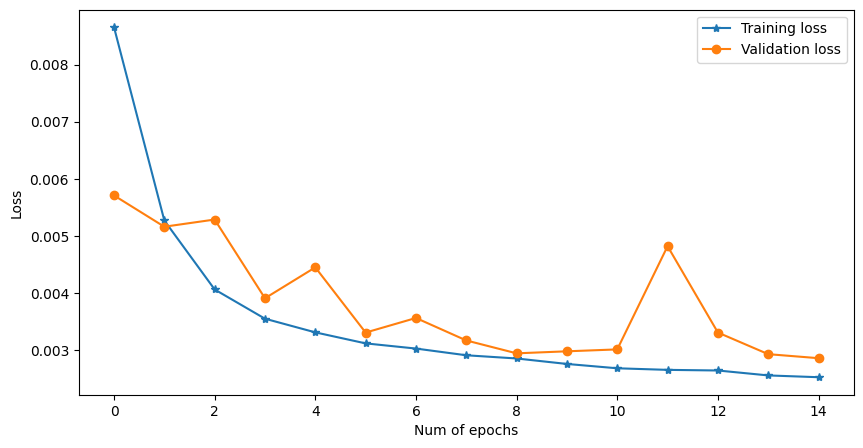

In [23]:
fig = plt.figure(figsize = (10, 5))
plt.plot(np.arange(n_epochs), train_losses, "*-",label = "Training loss")
plt.plot(np.arange(n_epochs), test_losses, "o-", label = "Validation loss")
plt.xlabel("Num of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Adversarial attacks functions

In [24]:
def fgsm_attack(input, epsilon, data_grad):
    perturbed_out = input + epsilon * data_grad.sign()

    return perturbed_out

In [25]:
def ifgsm_attack(input, epsilon, data_grad, max_iter = 10):
    max_iter = max_iter
    alpha = epsilon / max_iter
    for i in range(0, max_iter):
        perturbed_out = fgsm_attack(input, alpha, data_grad)
        perturbed_out.clip(input - epsilon, input + epsilon)

    return perturbed_out

In [64]:
def ADAtoModel(model, device, test_loader, epsilon, attack = 'fgsm'):
    perturbed_data = 0
    max_iter = 10
    correct = 0
    indxs = 0
    adv_examples = []
    initial_examples = []
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)

        init_pred = output.max(1)[1]

        # print('out', init_pred.shape)
        # print('tar', target)

        indexes_to_attack = torch.where(init_pred == target)[0]

        # print(indexes_to_attack)
        # print(data.shape)
        # print(target.shape)

        loss = loss_func(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data

        data_grad = data_grad[indexes_to_attack]
        data = data[indexes_to_attack]
        target = target[indexes_to_attack]

        initial_examples.append(data.detach().cpu().numpy())

        #perturbed_data = fgsm_attack(data, epsilon, data_grad)
        perturbed_data = ifgsm_attack(data, epsilon, data_grad, max_iter)

        output = model(perturbed_data)

        final_pred = output.max(1)[1]

        correct += (final_pred == target).sum()
        indxs += len(indexes_to_attack)

        # print(len(indexes_to_attack))
        # print(correct)

        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred, final_pred, adv_ex) )

    final_acc = correct / float(indxs)
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {indxs} = {final_acc}")

    return final_acc, adv_examples, initial_examples

In [65]:
epsilons = [0, 0.001, 0.0007, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]

accuracies = []
adv_examples = []
ini_examples = []
for eps in epsilons:
    acc, adv_ex, ini_ex  = ADAtoModel(model, device, test_loader, eps, 'fgsm')
    accuracies.append(acc)
    adv_examples.append(adv_ex)
    ini_examples.append(ini_ex)

Epsilon: 0	Test Accuracy = 1106 / 1106 = 1.0
Epsilon: 0.001	Test Accuracy = 1105 / 1106 = 0.9990958571434021
Epsilon: 0.0007	Test Accuracy = 1106 / 1106 = 1.0
Epsilon: 0.005	Test Accuracy = 1099 / 1106 = 0.9936709403991699
Epsilon: 0.01	Test Accuracy = 1094 / 1106 = 0.9891501069068909
Epsilon: 0.02	Test Accuracy = 1076 / 1106 = 0.9728752374649048
Epsilon: 0.05	Test Accuracy = 1035 / 1106 = 0.9358047246932983
Epsilon: 0.1	Test Accuracy = 971 / 1106 = 0.8779385685920715
Epsilon: 0.2	Test Accuracy = 867 / 1106 = 0.7839059829711914
Epsilon: 0.3	Test Accuracy = 771 / 1106 = 0.6971067190170288
Epsilon: 0.5	Test Accuracy = 627 / 1106 = 0.5669077634811401


In [66]:
initial = next(iter(test_loader))
initial[0].shape

torch.Size([128, 500, 1])

In [67]:
# init predict
adv_examples[0][0][0][0]

tensor(0, device='cuda:0')

In [68]:
# final predict
adv_examples[0][0][1][0]

tensor(0, device='cuda:0')

In [72]:
len(adv_examples)

11

In [73]:
len(ini_examples)

11

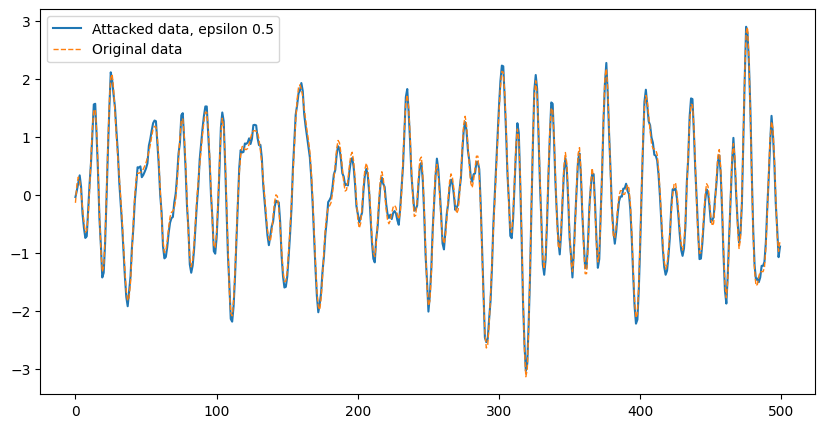

In [100]:
plt.figure(figsize = (10, 5))
i = 10
plt.plot(adv_examples[i][0][2][0], label = f'Attacked data, epsilon {epsilons[i]}')
plt.plot(ini_examples[i][0][0], "--", linewidth = 1, label = 'Original data')
#plt.xlim([-10, 110])
plt.legend();

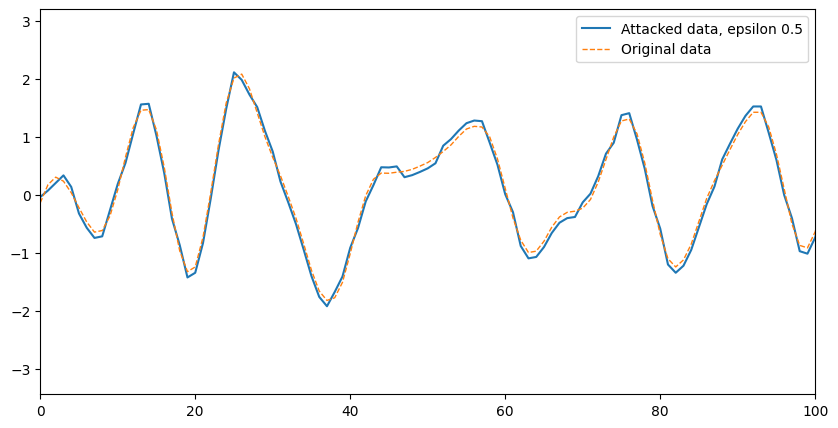

In [103]:
plt.figure(figsize = (10, 5))
plt.plot(adv_examples[i][0][2][0], label = f'Attacked data, epsilon {epsilons[i]}')
plt.plot(ini_examples[i][0][0], "--", linewidth = 1, label = 'Original data')
plt.xlim([0, 100])
plt.legend();

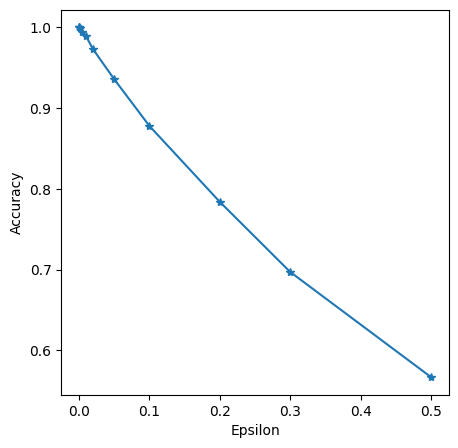

In [89]:
plt.figure(figsize = (5, 5))
plt.plot(epsilons, [tensor.item() for tensor in accuracies], "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()